In [31]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [32]:
# Getting the current directory
os.getcwd()

'f:\\Certified_freak_workspace\\MDS_Project\\Code'

In [33]:
# Setting the model parameters
BATCH_SIZE = 32  # What's the batch of training
IMAGE_SIZE = 256  # Size of image
CHANNELS = 3  # Type of image, in this case, 3 RGB Channels
EPOCHS = 10  # Training Cycles.

In [34]:
# Retriving the data from the files into the program.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "f:\\Certified_freak_workspace\\MDS_Project\\Dataset\\DatasetForPneumonia\\chest_xray\\chest_xray\\train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5216 files belonging to 2 classes.


In [35]:
# Getting class names.
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [36]:
# Getting the image as batch via loop
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]


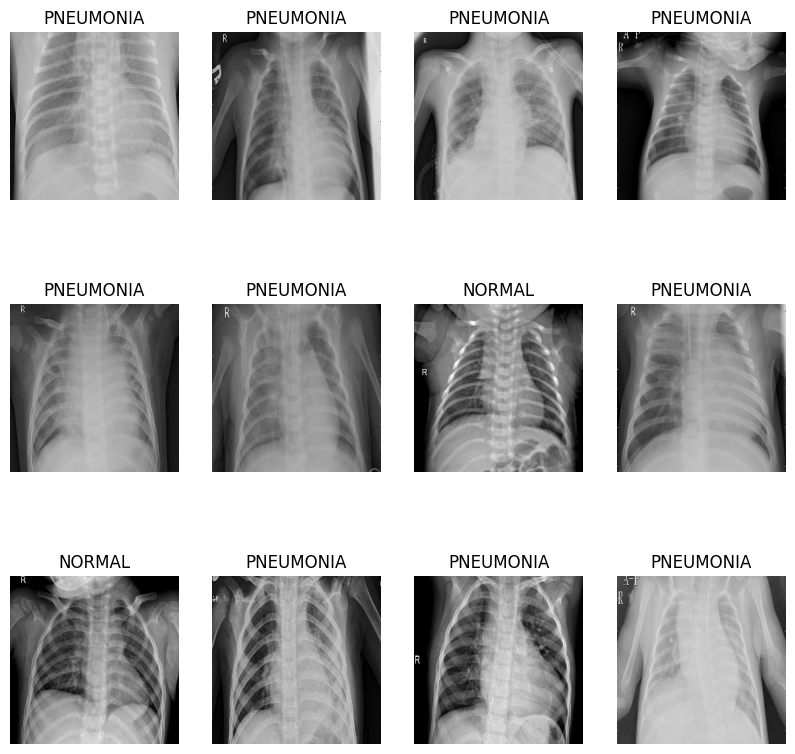

In [37]:
# Image showing with labels.
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [38]:
len(dataset)

163

In [39]:
train_size = 0.8
len(dataset)*train_size

130.4

In [40]:
train_ds = dataset.take(100)
len(train_ds)

100

In [41]:
test_ds = dataset.skip(100)
len(test_ds)

63

In [42]:
val_size = 0.1
len(dataset)*val_size

16.3

In [43]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [44]:
test_ds = test_ds.skip(7)
len(test_ds)

56

In [45]:
# Partition of data into Training, Testing, and Validation parts.
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [46]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [47]:
len(train_ds)

130

In [48]:
len(val_ds)

16

In [49]:
len(test_ds)

17

In [50]:
# cache shuffle prefetch - Cache for storing the memory, shuffle so that data goes random and prefetch so that tensorflow automatically determine the size of the data depending upon the memory.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
# normalise /255 - Image PreProcessing.
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [52]:
# horizontal contrast rotate zoom
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [53]:
# Applying the CNN algorithm via Tensorflow, Getting the model parameters,
# Making the NN layers via Convo2D, MaxPooling for focusing on the important parameters
# Flatten layers into 1D vector
# Dense used for fully connecting the layers.
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),  # img size reduction
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [54]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [55]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [56]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
130/130 [==============================] - 162s 1s/step - loss: 0.5633 - accuracy: 0.7577 - val_loss: 0.3747 - val_accuracy: 0.8770
Epoch 2/10
130/130 [==============================] - 141s 1s/step - loss: 0.1842 - accuracy: 0.9312 - val_loss: 0.1532 - val_accuracy: 0.9414
Epoch 3/10
130/130 [==============================] - 134s 1s/step - loss: 0.1136 - accuracy: 0.9565 - val_loss: 0.1124 - val_accuracy: 0.9727
Epoch 4/10
130/130 [==============================] - 125s 958ms/step - loss: 0.1029 - accuracy: 0.9611 - val_loss: 0.0869 - val_accuracy: 0.9746
Epoch 5/10
130/130 [==============================] - 116s 892ms/step - loss: 0.0763 - accuracy: 0.9721 - val_loss: 0.0685 - val_accuracy: 0.9785
Epoch 6/10
130/130 [==============================] - 120s 926ms/step - loss: 0.0683 - accuracy: 0.9736 - val_loss: 0.0720 - val_accuracy: 0.9785
Epoch 7/10
130/130 [==============================] - 124s 950ms/step - loss: 0.0580 - accuracy: 0.9796 - val_loss: 0.0727 - val_accu

In [57]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 17s 263ms/step - loss: 0.0339 - accuracy: 0.9835


In [58]:
scores

[0.0338977687060833, 0.9834558963775635]

In [59]:
history

In [60]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 130}

In [61]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
type(history.history['loss'])

list

In [63]:
len(history.history['loss'])

10

In [64]:
history.history['loss'][:5]  # show loss for first 5 epochs

[0.5633254647254944,
 0.184236541390419,
 0.11363964527845383,
 0.10289853066205978,
 0.07632478326559067]

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

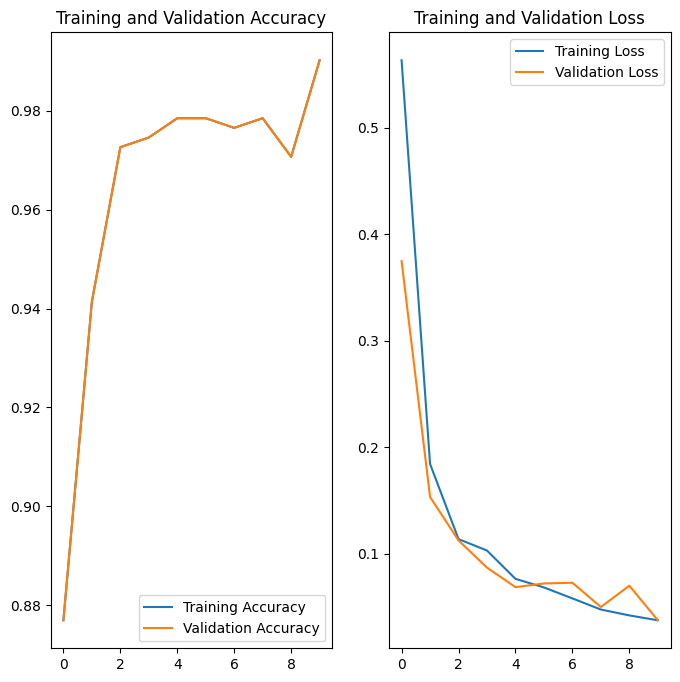

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), val_acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: PNEUMONIA
1/1 [==============================] - 0s 377ms/step
predicted label: PNEUMONIA


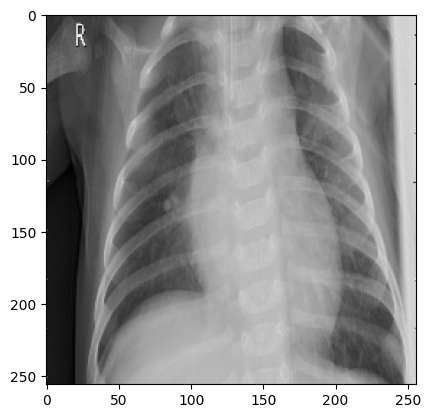

In [67]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [68]:
def predict(model, images):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


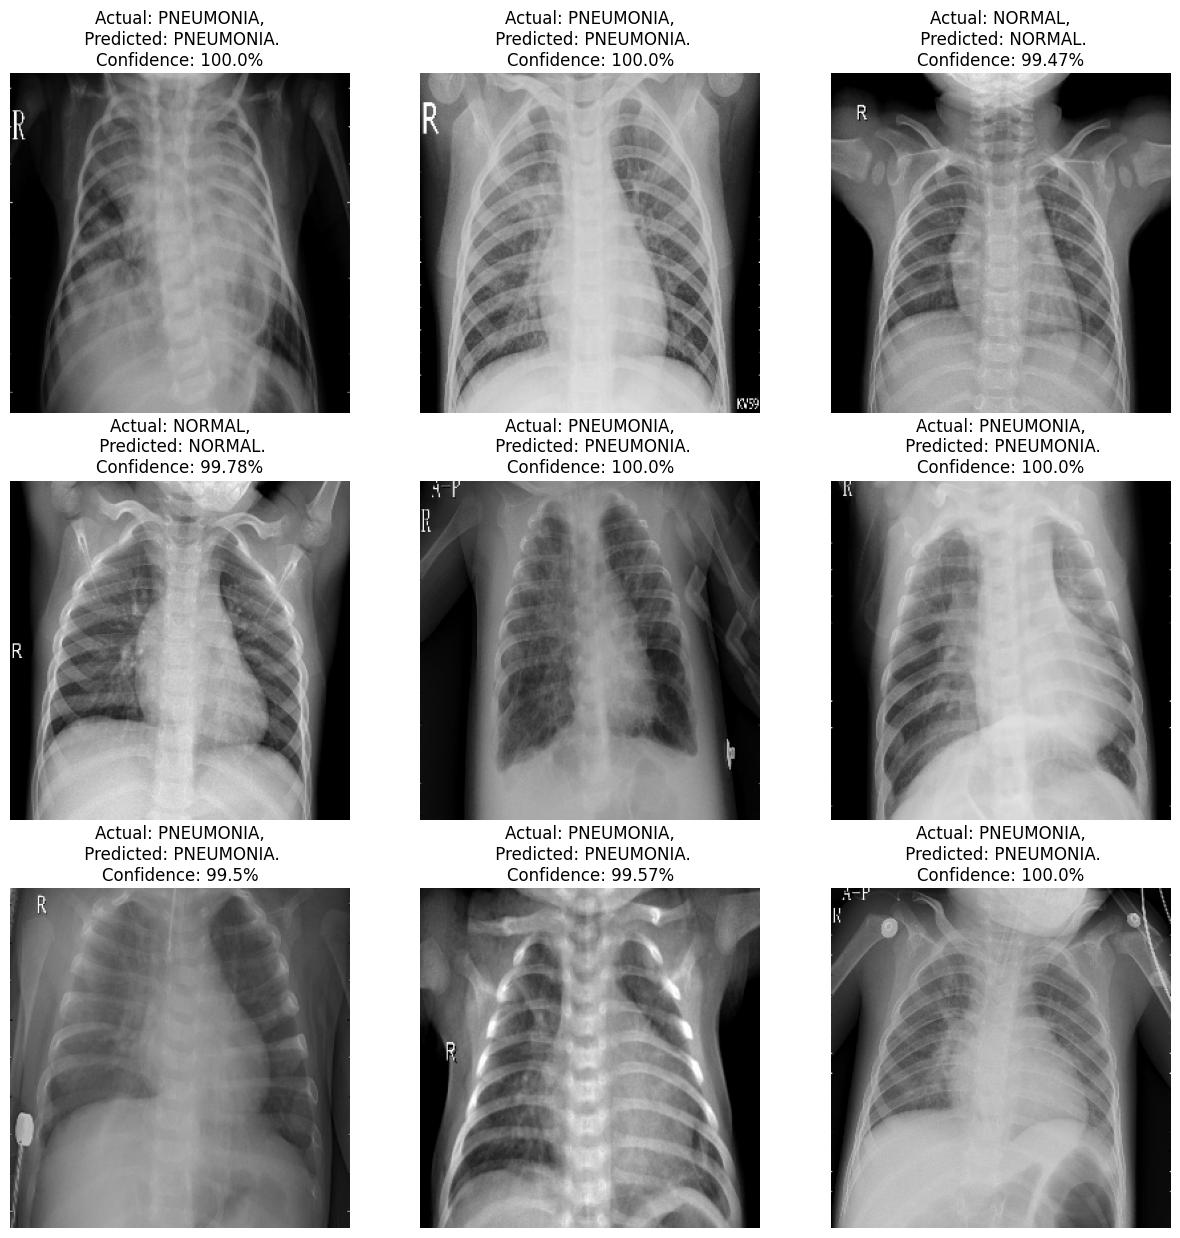

In [69]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(
            f"Actual: {actual_class},\n Predicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")

In [70]:
# ... (previous code)
# Calculate and print the accuracy score on the test dataset
test_scores = model.evaluate(test_ds)
test_accuracy = test_scores[1]
print("Test accuracy:", test_accuracy)

17/17 [==============================] - 4s 249ms/step - loss: 0.0339 - accuracy: 0.9835
Test accuracy: 0.9834558963775635


In [71]:
# model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/code/ patato_project/models") + [0]])+1
# model.save(f"/content/drive/MyDrive/code/patato_project/models/{model_version}")

1/1 [==============================] - 0s 286ms/step


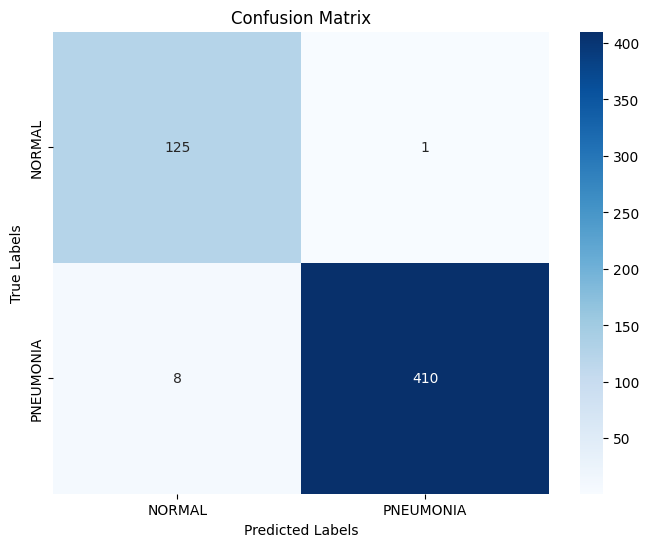

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.94      0.99      0.97       126
   PNEUMONIA       1.00      0.98      0.99       418

    accuracy                           0.98       544
   macro avg       0.97      0.99      0.98       544
weighted avg       0.98      0.98      0.98       544



In [72]:
# Load your model and test dataset if necessary
# model = tf.keras.models.load_model("D:\project 2023\model\model1.keras")
# Get true labels and predicted labels for the test dataset
true_labels = []
predicted_labels = []
for images_batch, labels_batch in test_ds:
    true_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))
# Define class names (adjust based on your dataset)
class_names = dataset.class_names
# Calculate confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Print classification report
classification_rep = classification_report(
    true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", classification_rep)

In [1]:
os.makedirs("/home/freak/Workspaces/Project_MDSU/Models/model")

NameError: name 'os' is not defined

In [2]:
model.save(r"/home/freak/Workspaces/Project_MDSU/Models/model/model.h5")

NameError: name 'model' is not defined